<a href="https://colab.research.google.com/github/memed01/DataScienceAndBigData/blob/master/Mendi_DecoderEncoder_Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train an autoencoder and use it to initialize a neural network

Fill in the missing code (autoencoder).

Train the autoencoder on the full unlabeled data.

Initialize a neural network with the `encoder` of the autoencoder.

Train the neural network on a reduced dataset.

In [0]:
import tensorflow as tf
#from keras.datasets import fashion_mnist
#from tf.keras.layers import Input, Dense, Reshape, Flatten, Dropout
#from keras.layers import BatchNormalization, Activation
#from keras.layers.advanced_activations import LeakyReLU
#from keras.models import Sequential, Model
#from keras.optimizers import Adam
import matplotlib.pyplot as plt
import sys
import numpy as np

Loading Fashion MNIST

In [0]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [0]:
X_train.shape, y_train.shape

((55000, 28, 28), (55000,))

**Data Preprocessing**
The images of the dataset are indeed grayscale images with pixel values ranging from 0 to 255 with a dimension of 28 x 28, so before we feed the data into the model, it is very important to preprocess it. You'll first convert each 28 x 28 image of train and test set into a matrix of size 28 x 28 x 1, which you can feed into the network:

In [0]:
# Image attributes
num_classes = 10
im_rows, im_cols= 28, 28
im_depth = 1
im_shape = (im_rows, im_cols, im_depth)

# Reshape the data

X_train = X_train.reshape(-1, im_rows, im_cols, im_depth)
X_valid = X_valid.reshape(-1, im_rows, im_cols, im_depth)
X_test = X_test.reshape(-1, im_rows, im_cols, im_depth)

# Validate the shape

print('X_train: {}'.format(X_train.shape))
print('y_train: {}'.format(y_train.shape))

print('X_valid: {}'.format(X_valid.shape))
print('y_valid: {}'.format(y_valid.shape))

print('X_test: {}'.format(X_test.shape))
print('y_test: {}'.format(y_test.shape))

X_train: (55000, 28, 28, 1)
y_train: (55000,)
X_valid: (5000, 28, 28, 1)
y_valid: (5000,)
X_test: (10000, 28, 28, 1)
y_test: (10000,)


In [0]:
np.max(X_train), np.max(X_test),np.max(X_valid)

(1.0, 1.0, 1.0)

In [0]:
def rounded_accuracy(y_true, y_pred):
    return tf.keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

Let's create separate encoder and decoder functions since you will be using encoder weights later on for classification purpose!

In [0]:
batch_size = 64
epochs = 20
input_img = tf.keras.layers.Input(im_shape)

In [0]:
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    drop1 = tf.keras.layers.Dropout(0.25)(pool1)
    conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(drop1) #14 x 14 x 64
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    drop3 = tf.keras.layers.Dropout(0.25)(conv3)
    conv4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(drop3) #7 x 7 x 256 (small and thick)
    conv4 = tf.keras.layers.BatchNormalization()(conv4)
    conv4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = tf.keras.layers.BatchNormalization()(conv4)
    return conv4

def decoder(conv4):    
    #decoder
    conv5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = tf.keras.layers.BatchNormalization()(conv5)
    conv5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = tf.keras.layers.BatchNormalization()(conv5)
    drop6 = tf.keras.layers.Dropout(0.25)(conv5)
    conv6 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(drop6) #7 x 7 x 64
    conv6 = tf.keras.layers.BatchNormalization()(conv6)
    conv6 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = tf.keras.layers.BatchNormalization()(conv6)
    drop7 = tf.keras.layers.Dropout(0.25)(conv6)
    up1 = tf.keras.layers.UpSampling2D((2,2))(drop7) #14 x 14 x 64
    conv7 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = tf.keras.layers.BatchNormalization()(conv7)
    conv7 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = tf.keras.layers.BatchNormalization()(conv7)
    up2 = tf.keras.layers.UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [0]:
autoencoder = tf.keras.Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='binary_crossentropy', optimizer = tf.keras.optimizers.SGD(learning_rate=0.1),metrics=[rounded_accuracy])
history = autoencoder.fit(X_train, X_train, epochs=epochs,
                           validation_data=[X_valid, X_valid])

Epoch 1/20
1719/1719 [==============================] - 24s 14ms/step - loss: 0.3146 - rounded_accuracy: 0.9072 - val_loss: 0.0000e+00 - val_rounded_accuracy: 0.0000e+00
Epoch 2/20
1719/1719 [==============================] - 24s 14ms/step - loss: 0.2905 - rounded_accuracy: 0.9244 - val_loss: 0.0000e+00 - val_rounded_accuracy: 0.0000e+00
Epoch 3/20
1719/1719 [==============================] - 24s 14ms/step - loss: 0.2850 - rounded_accuracy: 0.9296 - val_loss: 0.0000e+00 - val_rounded_accuracy: 0.0000e+00
Epoch 4/20
1719/1719 [==============================] - 24s 14ms/step - loss: 0.2814 - rounded_accuracy: 0.9331 - val_loss: 0.0000e+00 - val_rounded_accuracy: 0.0000e+00
Epoch 5/20
1719/1719 [==============================] - 24s 14ms/step - loss: 0.2792 - rounded_accuracy: 0.9352 - val_loss: 0.0000e+00 - val_rounded_accuracy: 0.0000e+00
Epoch 6/20
1719/1719 [==============================] - 24s 14ms/step - loss: 0.2774 - rounded_accuracy: 0.9370 - val_loss: 0.0000e+00 - val_rounded_a

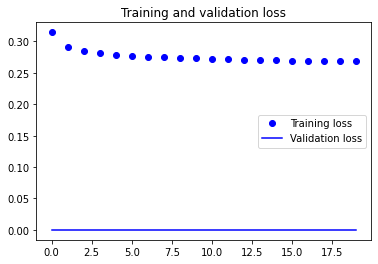

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(20)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
autoencoder.save_weights('autoencoder.h5')

**Segmenting the fashion mnist images**

Now we will use the trained autoencoder and will load the weights of the autoencoder we just now trained but only in the encoder part of the model.

You will add a few dense or fully connected layers to the encoder to classify fashion mnist images.

Let's first convert the labels into one-hot encoding vectors.

In [0]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = tf.keras.utils.to_categorical(y_train_full)
test_Y_one_hot = tf.keras.utils.to_categorical(y_test)

# Display the change for category label using one-hot encoding
print('Original label:', y_train[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 9
After conversion to one-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [0]:
#X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
train_label,valid_label = train_Y_one_hot[:-5000], train_Y_one_hot[-5000:]

you will be using the exact same encoder part as we used in the autoencoder architecture.

In [0]:
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    drop1 = tf.keras.layers.Dropout(0.25)(pool1)
    conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(drop1) #14 x 14 x 64
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    drop3 = tf.keras.layers.Dropout(0.25)(conv3)
    conv4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(drop3) #7 x 7 x 256 (small and thick)
    conv4 = tf.keras.layers.BatchNormalization()(conv4)
    conv4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = tf.keras.layers.BatchNormalization()(conv4)
    return conv4

Let's define the fully connected layers that you will be stacking up with the encoder function.



In [0]:
def fc(enco):
    flat = tf.keras.layers.Flatten()(enco)
    den = tf.keras.layers.Dense(128, activation='relu')(flat)
    out = tf.keras.layers.Dense(num_classes, activation='softmax')(den)
    return out

In [0]:
encode = encoder(input_img)
full_model = tf.keras.Model(input_img,fc(encode))

In [0]:
for l1,l2 in zip(full_model.layers[:19],autoencoder.layers[0:19]):
    l1.set_weights(l2.get_weights())

Let's print first layer weights of both the models,in order to be sure whether the weights of the encoder part of the autoencoder are similar to the weights we loaded to the encoder function of the classification model 

In [0]:
autoencoder.get_weights()[0][1]-full_model.get_weights()[0][1]

array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]],
      dtype=float32)

Both the arrays look exactly similar. So, let's compile the model and start the training.

Next, we will make the encoder part i.e.the first nineteen layers of the model trainable false. 

Since the encoder part is already trained, we do not need to train it. we will only be training the Fully Connected part.

In [0]:
for layer in full_model.layers[0:19]:
    layer.trainable = False

Let's compile the model!

In [0]:
full_model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])

In [0]:
full_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_70 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_71 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 32)        0   

In [0]:
classify_train = full_model.fit(X_train, train_label, batch_size=64,epochs=20,verbose=1,validation_data=(X_valid, valid_label))

Epoch 1/20
860/860 [==============================] - 8s 9ms/step - loss: 0.4294 - accuracy: 0.8513 - val_loss: 0.3273 - val_accuracy: 0.8756
Epoch 2/20
860/860 [==============================] - 8s 9ms/step - loss: 0.3170 - accuracy: 0.8820 - val_loss: 0.2938 - val_accuracy: 0.8888
Epoch 3/20
860/860 [==============================] - 8s 9ms/step - loss: 0.2875 - accuracy: 0.8927 - val_loss: 0.2915 - val_accuracy: 0.8954
Epoch 4/20
860/860 [==============================] - 8s 9ms/step - loss: 0.2687 - accuracy: 0.8997 - val_loss: 0.2960 - val_accuracy: 0.8970
Epoch 5/20
860/860 [==============================] - 8s 9ms/step - loss: 0.2519 - accuracy: 0.9046 - val_loss: 0.3000 - val_accuracy: 0.8928
Epoch 6/20
860/860 [==============================] - 8s 9ms/step - loss: 0.2478 - accuracy: 0.9079 - val_loss: 0.2699 - val_accuracy: 0.9034
Epoch 7/20
860/860 [==============================] - 8s 9ms/step - loss: 0.2360 - accuracy: 0.9119 - val_loss: 0.2927 - val_accuracy: 0.8964
Epoch 

After just 20 epochs, and by observing the training accuracy and loss, you can say that the model did better job since the training accuracy is 94% and the validation accuracy is 90%

In [0]:
#Let's save the classification model!
full_model.save_weights('autoencoder_classification.h5')

Let's us re-train the model by making the first nineteen layers trainable as True

In [0]:
for layer in full_model.layers[0:19]:
    layer.trainable = True

In [0]:
full_model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])

Now let's train the entire model for one last time.

In [0]:
classify_train = full_model.fit(X_train, train_label, batch_size=64,epochs=100,verbose=1,validation_data=(X_valid, valid_label))

Epoch 1/100
860/860 [==============================] - 15s 17ms/step - loss: 0.2690 - accuracy: 0.9011 - val_loss: 0.2676 - val_accuracy: 0.9056
Epoch 2/100
860/860 [==============================] - 15s 17ms/step - loss: 0.2027 - accuracy: 0.9240 - val_loss: 0.2671 - val_accuracy: 0.9068
Epoch 3/100
860/860 [==============================] - 15s 17ms/step - loss: 0.1812 - accuracy: 0.9318 - val_loss: 0.2709 - val_accuracy: 0.9034
Epoch 4/100
860/860 [==============================] - 15s 17ms/step - loss: 0.1666 - accuracy: 0.9374 - val_loss: 0.2567 - val_accuracy: 0.9152
Epoch 5/100
860/860 [==============================] - 15s 17ms/step - loss: 0.1573 - accuracy: 0.9416 - val_loss: 0.2665 - val_accuracy: 0.9136
Epoch 6/100
860/860 [==============================] - 15s 17ms/step - loss: 0.1375 - accuracy: 0.9492 - val_loss: 0.2623 - val_accuracy: 0.9132
Epoch 7/100
860/860 [==============================] - 15s 17ms/step - loss: 0.1273 - accuracy: 0.9521 - val_loss: 0.2642 - val_ac

Let' us saved the model for the last time

In [0]:
full_model.save_weights('classification_complete.h5')

Let's put your model evaluation into perspective and plot the accuracy and loss plots between training and validation data:

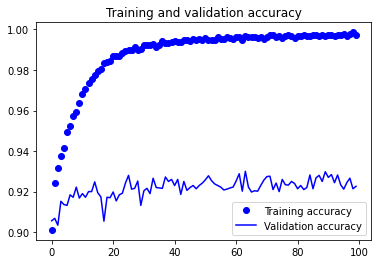

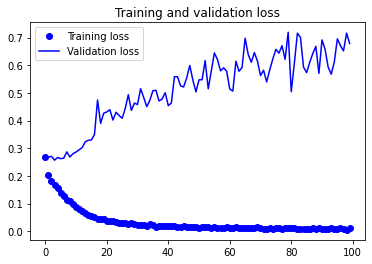

In [0]:
accuracy = classify_train.history['accuracy']
val_accuracy = classify_train.history['val_accuracy']
loss = classify_train.history['loss']
val_loss = classify_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

From the above two plots, we can see that the model is overfitting since there is a big gap between the training and validation loss. In order to address overfitting, you will have to add to Dropout other regularization techniques like [L2 Regulirazation](https://en.wikipedia.org/wiki/Regularization_(mathematics)).

**Model Evaluation on the Test Set**

Let's evaluate your model on test data and see how it performs!

In [0]:
test_eval = full_model.evaluate(X_test, test_Y_one_hot, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.7071596384048462
Test accuracy: 0.9286999702453613


**Predict Labels**

In [0]:
predicted_classes1 = full_model.predict(X_test)

In [0]:
predicted_classes1

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

We will use argmax() of numpy to return indices with 1

In [0]:
predicted_classes = np.argmax(np.round(predicted_classes1),axis=1)

In [0]:
predicted_classes

array([9, 2, 1, ..., 8, 1, 5])

In [0]:
predicted_classes.shape, y_test.shape

((10000,), (10000,))

Found 9287 correct labels


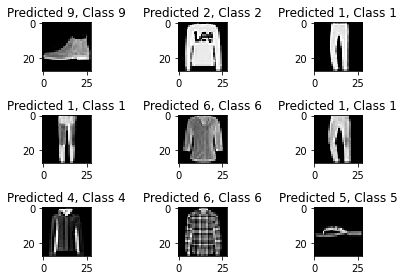

In [0]:
correct = np.where(predicted_classes==y_test)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(im_rows, im_cols), cmap='gray', interpolation='none')
    plt.title("Pred {}, Name {}".format(predicted_classes[correct], y_test[correct]))
    plt.tight_layout()

Found 713 incorrect labels


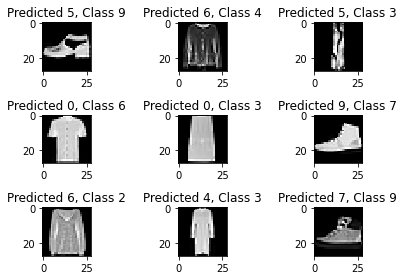

In [0]:
incorrect = np.where(predicted_classes!=y_test)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(im_rows, im_cols), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))
    plt.tight_layout()

**Classification Report**

In [0]:
import pandas as pd

In [0]:
Label_Description={'0':	'T-shirt/top','1':	'Trouser','2':	'Pullover','3':	'Dress',
                   '4':	'Coat','5':	'Sandal','6':  'Shirt',
                   '7': 'Sneaker','8': 'Bag','9': 'Ankle boot'}

In [0]:
Label_Name=pd.Series(Label_Description)

In [0]:
from sklearn.metrics import classification_report
target_names = [Label_Name[i] for i in range(num_classes)]
print(classification_report(y_test, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

 T-shirt/top       0.88      0.88      0.88      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.89      0.88      0.89      1000
       Dress       0.94      0.92      0.93      1000
        Coat       0.88      0.91      0.89      1000
      Sandal       0.99      0.99      0.99      1000
       Shirt       0.80      0.79      0.79      1000
     Sneaker       0.97      0.97      0.97      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.97      0.98      0.98      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



We see that the pants, sandals, bags, boots and sneakers are well classified, on the other hand the model worked moderately for the shirts.